In [9]:
#!pip install tensorflow keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
import h5py


In [10]:
#from google.colab import drive
#drive.mount('/content/drive/')
#data_dir = '/content/drive/MyDrive/BiologicalData/biological_data_pfp/train/'


In [11]:
data_dir = 'data/train/'

In [12]:
# Loading train_set.tsv file, which contains ProteinID, aspect and GO_term

train_set = pd.read_csv(data_dir+'train_set.tsv', delimiter='\t')
train_set.head()

,Protein_ID,aspect,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226


In [13]:
# Load train_ids.txt, which contains all of the Protein_IDs

train_ids_df = pd.read_csv(data_dir+'train_ids.txt',header = None)
train_ids_df.columns = ['Protein_ID']
train_ids_df.head()

,Protein_ID
0,P91124
1,Q55DL5
2,O81027
3,Q04418
4,Q8IXT2


In [14]:
# Load train_embeddings.h5 containing the prott5 embeddings

train_embeddings = []
protein_ids = []

with h5py.File(data_dir+'train_embeddings.h5', 'r') as f:
    for protein_id in f.keys():  # protein ids
        embeddings = f[protein_id][:]
        train_embeddings.append(embeddings)
        protein_ids.append(protein_id)

# Convert the list of embeddings to a numpy array
prott5_embeddings = np.array(train_embeddings)

# Create a DataFrame from the embeddings array
column_num = prott5_embeddings.shape[1]
train_df = pd.DataFrame(prott5_embeddings, columns=["Column_" + str(i) for i in range(1, column_num + 1)])

# Set protein_ids as the index of the DataFrame
#train_df.index = protein_ids

print(train_df.shape)
train_df.head()

(123969, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.068176,-0.046478,0.001752,-0.008583,0.003763,0.046265,-0.059662,-0.050385,-0.005173,0.008865,...,-0.040771,-0.013138,-0.049591,-0.101074,0.066406,0.008980,-0.003506,-0.024612,0.034760,-0.031006
1,-0.016434,-0.001583,0.003889,0.073425,0.012428,0.028168,-0.040375,-0.093811,-0.017807,0.025497,...,0.011879,-0.033325,-0.031342,-0.005245,0.014732,0.081970,0.017456,-0.032959,0.053192,0.029907
2,0.007904,0.087708,-0.001715,0.037659,0.017883,0.025589,-0.011749,-0.084717,-0.016266,-0.034973,...,0.004829,-0.049713,-0.027176,-0.037415,-0.006241,-0.039703,0.001784,0.004719,-0.004288,0.001847
3,0.002447,0.007053,0.064453,0.007271,-0.033569,-0.009933,-0.022186,-0.083862,-0.003841,-0.018631,...,-0.053589,-0.002508,-0.016647,-0.069458,0.042206,-0.051758,-0.025436,0.057373,0.099121,0.032898
4,0.049316,0.020691,0.108643,0.016342,-0.051056,-0.017334,-0.042084,-0.154053,0.007347,0.029907,...,-0.100647,-0.063293,0.002346,-0.104675,-0.000757,-0.047485,0.003002,-0.036774,0.103577,0.005245


In [8]:
# Load the dataset
#train_set = pd.read_csv(data_dir+'train_set.tsv', delimiter='\t')
#
#protein_sequences = {}
#with open(data_dir+'train.fasta', 'r') as fasta_file:
#    current_protein = ''
#    for line in fasta_file:
#        if line.startswith('>'):
#            current_protein = line.strip()[1:]
#            protein_sequences[current_protein] = ''
#        else:
#            protein_sequences[current_protein] += line.strip()
#
#
## Load train_protein2ipr dat file
#
#train_protein2ipr = pd.read_csv(data_dir+'train_protein2ipr.dat',header = None, sep='\t')
#train_protein2ipr.columns = ['Protein_ID','IPR_ID','desc','db','start','end']
#

(1024,)
(123969, 1024)


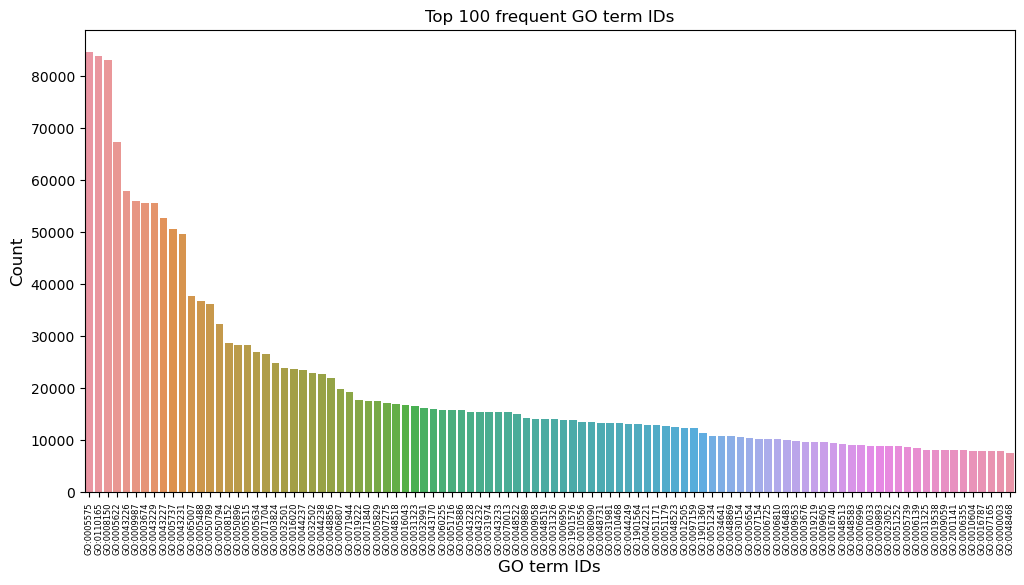

In [15]:
# Select first 1500 values for plotting

import seaborn as sns
plot_df = train_set['GO_term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [16]:
train_set.head()

,Protein_ID,aspect,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226


In [17]:
print(train_set.shape)
print(train_df.shape)

(4277047, 3)
(123969, 1024)


In [18]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels

labels = train_set['GO_term'].value_counts().index[:num_of_labels].tolist()
# note added filtering for ONLY cellular component
#train_set_updated = train_set.loc[train_set['GO_term'].isin(labels)]
train_set_updated = train_set.loc[train_set['GO_term'].isin(labels) & (train_set['aspect'] == 'cellular_component')]

In [19]:
train_set_updated.head()

,Protein_ID,aspect,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226


In [31]:
len(labels)

1500

In [30]:
train_set_updated.groupby('GO_term').count()['Protein_ID'].to_dict()

{'GO:0000139': 690,
 'GO:0000151': 615,
 'GO:0000228': 785,
 'GO:0000313': 431,
 'GO:0000322': 632,
 'GO:0000323': 1826,
 'GO:0000324': 605,
 'GO:0000325': 794,
 'GO:0000428': 403,
 'GO:0000775': 754,
 'GO:0000776': 483,
 'GO:0000779': 527,
 'GO:0000785': 2214,
 'GO:0000793': 867,
 'GO:0005575': 84638,
 'GO:0005576': 6525,
 'GO:0005615': 4909,
 'GO:0005618': 1500,
 'GO:0005622': 67293,
 'GO:0005634': 26986,
 'GO:0005635': 1407,
 'GO:0005654': 10498,
 'GO:0005667': 1041,
 'GO:0005681': 540,
 'GO:0005694': 4008,
 'GO:0005730': 3069,
 'GO:0005737': 50729,
 'GO:0005739': 8681,
 'GO:0005740': 2060,
 'GO:0005741': 495,
 'GO:0005743': 1360,
 'GO:0005759': 1137,
 'GO:0005761': 425,
 'GO:0005764': 1213,
 'GO:0005765': 569,
 'GO:0005768': 2093,
 'GO:0005769': 569,
 'GO:0005770': 510,
 'GO:0005773': 3063,
 'GO:0005774': 1178,
 'GO:0005777': 964,
 'GO:0005783': 5334,
 'GO:0005788': 384,
 'GO:0005789': 1585,
 'GO:0005794': 3924,
 'GO:0005795': 391,
 'GO:0005802': 635,
 'GO:0005813': 1298,
 'GO:0005

In [29]:
np.sum(list(metric_label_weights.values()))

697.8026666666667

In [28]:
max(list(metric_label_weights.values()))

56.425333333333334

In [27]:
len(train_set_updated)

1046704

In [26]:
sum_weights

1046704

In [24]:
train_set_updated.groupby('GO_term').count()['Protein_ID'].to_dict()

{'GO:0000139': 690,
 'GO:0000151': 615,
 'GO:0000228': 785,
 'GO:0000313': 431,
 'GO:0000322': 632,
 'GO:0000323': 1826,
 'GO:0000324': 605,
 'GO:0000325': 794,
 'GO:0000428': 403,
 'GO:0000775': 754,
 'GO:0000776': 483,
 'GO:0000779': 527,
 'GO:0000785': 2214,
 'GO:0000793': 867,
 'GO:0005575': 84638,
 'GO:0005576': 6525,
 'GO:0005615': 4909,
 'GO:0005618': 1500,
 'GO:0005622': 67293,
 'GO:0005634': 26986,
 'GO:0005635': 1407,
 'GO:0005654': 10498,
 'GO:0005667': 1041,
 'GO:0005681': 540,
 'GO:0005694': 4008,
 'GO:0005730': 3069,
 'GO:0005737': 50729,
 'GO:0005739': 8681,
 'GO:0005740': 2060,
 'GO:0005741': 495,
 'GO:0005743': 1360,
 'GO:0005759': 1137,
 'GO:0005761': 425,
 'GO:0005764': 1213,
 'GO:0005765': 569,
 'GO:0005768': 2093,
 'GO:0005769': 569,
 'GO:0005770': 510,
 'GO:0005773': 3063,
 'GO:0005774': 1178,
 'GO:0005777': 964,
 'GO:0005783': 5334,
 'GO:0005788': 384,
 'GO:0005789': 1585,
 'GO:0005794': 3924,
 'GO:0005795': 391,
 'GO:0005802': 635,
 'GO:0005813': 1298,
 'GO:0005

In [32]:
metric_label_weights = train_set_updated.groupby('GO_term').count()['Protein_ID'].to_dict()
sum_weights = np.sum(list(metric_label_weights.values()))
for term in metric_label_weights:
    metric_label_weights[term] /= num_of_labels #float(sum_weights)
metric_label_weights

{'GO:0000139': 0.46,
 'GO:0000151': 0.41,
 'GO:0000228': 0.5233333333333333,
 'GO:0000313': 0.28733333333333333,
 'GO:0000322': 0.42133333333333334,
 'GO:0000323': 1.2173333333333334,
 'GO:0000324': 0.4033333333333333,
 'GO:0000325': 0.5293333333333333,
 'GO:0000428': 0.26866666666666666,
 'GO:0000775': 0.5026666666666667,
 'GO:0000776': 0.322,
 'GO:0000779': 0.35133333333333333,
 'GO:0000785': 1.476,
 'GO:0000793': 0.578,
 'GO:0005575': 56.425333333333334,
 'GO:0005576': 4.35,
 'GO:0005615': 3.272666666666667,
 'GO:0005618': 1.0,
 'GO:0005622': 44.862,
 'GO:0005634': 17.990666666666666,
 'GO:0005635': 0.938,
 'GO:0005654': 6.998666666666667,
 'GO:0005667': 0.694,
 'GO:0005681': 0.36,
 'GO:0005694': 2.672,
 'GO:0005730': 2.046,
 'GO:0005737': 33.81933333333333,
 'GO:0005739': 5.787333333333334,
 'GO:0005740': 1.3733333333333333,
 'GO:0005741': 0.33,
 'GO:0005743': 0.9066666666666666,
 'GO:0005759': 0.758,
 'GO:0005761': 0.2833333333333333,
 'GO:0005764': 0.8086666666666666,
 'GO:000576

(array([211.,  10.,   3.,   1.,   0.,   2.,   3.,   1.,   0.,   2.]),
 array([ 0.256     ,  5.87293333, 11.48986667, 17.1068    , 22.72373333,
        28.34066667, 33.9576    , 39.57453333, 45.19146667, 50.8084    ,
        56.42533333]),
 <BarContainer object of 10 artists>)

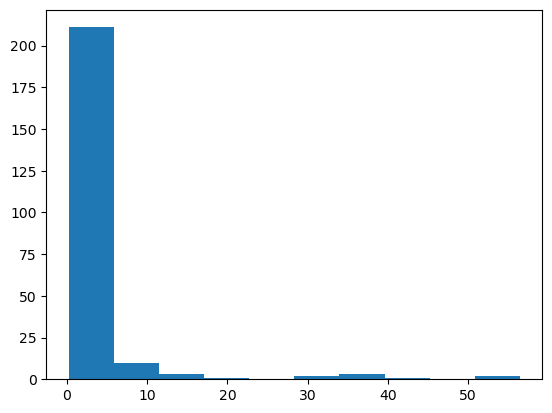

In [33]:
plt.hist(list(metric_label_weights.values()))

In [34]:
print(prott5_embeddings.shape)
print(train_set.shape)

(123969, 1024)
(4277047, 3)


In [35]:
GO_dist = train_set.groupby('GO_term').count()['Protein_ID'].sort_values(ascending=False)
GO_dist

GO_term
GO:0005575    84638
GO:0110165    83893
GO:0008150    83064
GO:0005622    67293
GO:0043226    58004
              ...  
GO:0015038       49
GO:0042169       49
GO:0016894       48
GO:0140463       48
GO:0005160       48
Name: Protein_ID, Length: 3004, dtype: int64

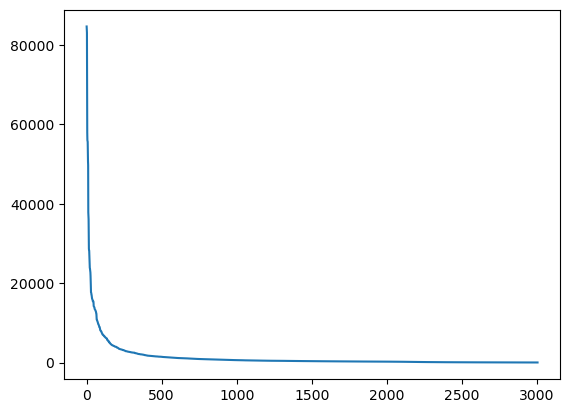

In [12]:
plt.plot(GO_dist.reset_index()['Protein_ID'])

In [13]:
#currently not using
subset_train_set[subset_train_set['Protein_ID']=='P39073']

NameError: name 'subset_train_set' is not defined

In [22]:
#currently not using
subset_train_set[subset_train_set['aspect']=='cellular_component']['GO_term']


2        GO:0005622
8        GO:0043231
10       GO:0005743
13       GO:0043229
15       GO:0097060
            ...    
99981    GO:0110165
99982    GO:0005634
99988    GO:0043233
99995    GO:0098588
99997    GO:0097708
Name: GO_term, Length: 26183, dtype: object

In [24]:
subset_train_set

,Protein_ID,aspect,GO_term
0,P39073,biological_process,GO:1901575
1,P15533,biological_process,GO:0008152
2,P61175,cellular_component,GO:0005622
3,O88875,biological_process,GO:0010556
4,Q06496,molecular_function,GO:1901702
...,...,...,...
99995,Q920N7,cellular_component,GO:0098588
99996,Q59DW8,biological_process,GO:1902904
99997,C8V0L5,cellular_component,GO:0097708
99998,Q681X4,biological_process,GO:0010468


In [36]:
train_set[train_set['aspect']=='cellular_component']['GO_term']

0          GO:0005575
1          GO:0110165
2          GO:0005737
3          GO:0005622
4          GO:0043226
              ...    
4277036    GO:0043226
4277037    GO:0005739
4277038    GO:0043231
4277039    GO:0043227
4277040    GO:0043229
Name: GO_term, Length: 1109632, dtype: object

In [37]:
train_set.head()

,Protein_ID,aspect,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226


In [31]:
#currently not using
subset_size = 100000
#subset_train_set = train_set[train_set['aspect']=='cellular_component']['GO_term']
subset_train_set = train_set.head(subset_size)

In [14]:
#currently not using
subset_train_set = train_set.sample(frac=1, random_state=42)
subset_train_set.reset_index(drop=True, inplace=True)
subset_train_set = subset_train_set.head(subset_size)

label_encoder_mf = LabelEncoder()
labels_mf = label_encoder_mf.fit_transform(subset_train_set[subset_train_set['aspect'] == 'molecular_function']['GO_term'])
labels_mf = to_categorical(labels_mf)

label_encoder_bp = LabelEncoder()
labels_bp = label_encoder_bp.fit_transform(subset_train_set[subset_train_set['aspect'] == 'biological_process']['GO_term'])
labels_bp = to_categorical(labels_bp)

label_encoder_cc = LabelEncoder()
labels_cc = label_encoder_cc.fit_transform(subset_train_set[subset_train_set['aspect'] == 'cellular_component']['GO_term'])
labels_cc = to_categorical(labels_cc)


In [15]:
#currently not using

# Map protein IDs to their corresponding ProtT5 embeddings
protein_id_to_embedding = dict(zip(train_set['Protein_ID'], prott5_embeddings))


X = []
y_mf, y_bp, y_cc = [], [], []

for protein_id, label_mf, label_bp, label_cc in zip(train_set['Protein_ID'], labels_mf, labels_bp, labels_cc):
    #sequence = protein_sequences.get(protein_id, '')  # Get protein sequence from fasta file
    embedding = protein_id_to_embedding.get(protein_id, [])  # Get ProtT5 embedding

    # Ensure embedding is available
    if len(embedding) > 0:
        X.append(embedding)  # Use ProtT5 embedding as input
        y_mf.append(label_mf)
        y_bp.append(label_bp)
        y_cc.append(label_cc)

# Convert lists to arrays
X = np.array(X)
y_mf = np.array(y_mf)
y_bp = np.array(y_bp)
y_cc = np.array(y_cc)

num_classes_mf = y_mf.shape[1]#len(np.unique(labels_mf))
num_classes_bp = y_bp.shape[1]#len(np.unique(labels_bp))
num_classes_cc = y_cc.shape[1]#len(np.unique(labels_cc))

#df = pd.DataFrame({'y_mf':y_mf, 'y_bp':y_bp, 'y_cc':y_cc})


In [38]:


# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = np.array(protein_ids).shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(protein_ids)

# Loop through each label
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_set_updated[train_set_updated['GO_term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['Protein_ID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

(123969, 1500)


In [39]:
labels_df.head()

,GO:0005575,GO:0110165,GO:0008150,GO:0005622,GO:0043226,GO:0009987,GO:0003674,GO:0043229,GO:0043227,GO:0005737,...,GO:0005244,GO:0009913,GO:1905039,GO:0030098,GO:0031507,GO:0071852,GO:0120032,GO:0031461,GO:0000075,GO:0005788
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
train_df

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.068176,-0.046478,0.001752,-0.008583,0.003763,0.046265,-0.059662,-0.050385,-0.005173,0.008865,...,-0.040771,-0.013138,-0.049591,-0.101074,0.066406,0.008980,-0.003506,-0.024612,0.034760,-0.031006
1,-0.016434,-0.001583,0.003889,0.073425,0.012428,0.028168,-0.040375,-0.093811,-0.017807,0.025497,...,0.011879,-0.033325,-0.031342,-0.005245,0.014732,0.081970,0.017456,-0.032959,0.053192,0.029907
2,0.007904,0.087708,-0.001715,0.037659,0.017883,0.025589,-0.011749,-0.084717,-0.016266,-0.034973,...,0.004829,-0.049713,-0.027176,-0.037415,-0.006241,-0.039703,0.001784,0.004719,-0.004288,0.001847
3,0.002447,0.007053,0.064453,0.007271,-0.033569,-0.009933,-0.022186,-0.083862,-0.003841,-0.018631,...,-0.053589,-0.002508,-0.016647,-0.069458,0.042206,-0.051758,-0.025436,0.057373,0.099121,0.032898
4,0.049316,0.020691,0.108643,0.016342,-0.051056,-0.017334,-0.042084,-0.154053,0.007347,0.029907,...,-0.100647,-0.063293,0.002346,-0.104675,-0.000757,-0.047485,0.003002,-0.036774,0.103577,0.005245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123964,0.052277,-0.062469,0.046478,0.046082,-0.041992,-0.009956,0.027161,-0.061401,0.038422,0.040039,...,-0.036865,-0.017426,0.019196,-0.034882,-0.044739,0.024338,-0.055084,0.013901,0.059326,0.014725
123965,-0.011299,-0.036957,0.029297,0.031891,0.006027,0.079468,-0.014832,-0.047791,0.055023,0.035706,...,-0.040680,-0.006996,0.018005,-0.024414,0.061401,0.041229,-0.021011,-0.014709,0.019791,0.052887
123966,0.040405,-0.013908,0.025421,0.075012,-0.050293,0.058685,-0.032135,-0.073975,0.061798,-0.004246,...,-0.066711,-0.011276,0.002800,-0.014954,0.015190,0.010483,-0.010162,0.027557,0.027039,0.017517
123967,-0.008362,-0.026291,0.037354,0.033264,-0.044861,-0.003189,-0.009598,-0.061432,0.027451,-0.015350,...,-0.037476,-0.020966,0.011360,0.027267,-0.006855,-0.005241,-0.057404,-0.012024,0.000682,0.045898


In [91]:
full_train_df, full_train_lables = train_df.copy(), train_labels.copy()

In [92]:
#  Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    full_train_df,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
class CustomPrecision(tf.keras.metrics.Metric):
    def __init__(self, name='custom_precision', **kwargs):
        super(CustomPrecision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)

        true_positives = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_positives, self.dtype)))
        self.predicted_positives.assign_add(tf.reduce_sum(tf.cast(y_pred, self.dtype)))

    def result(self):
        precision = self.true_positives / (self.predicted_positives + tf.keras.backend.epsilon())
        return precision

    def reset_states(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)

In [20]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class AverageRecall(Metric):
    def __init__(self, name='average_recall', **kwargs):
        super(AverageRecall, self).__init__(name=name, **kwargs)
        self.recall = tf.keras.metrics.Recall()
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.recall.update_state(y_true, y_pred, sample_weight)
        self.total.assign_add(self.recall.result())
        self.count.assign_add(1)
        self.recall.reset_states()

    def result(self):
        return self.total / self.count

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)
        self.recall.reset_states()

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [94]:
import tensorflow as tf
INPUT_SHAPE = [train_df.shape[1]]
BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC(multi_label=True, curve='PR', name='average_precision')]
)

hist = model.fit(
    train_df, labels_df,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=200
)

Epoch 1/200
25/25 [==============================] - 15s 513ms/step - loss: 0.1481 - binary_accuracy: 0.9509 - average_precision: 0.0059 - val_loss: 0.1270 - val_binary_accuracy: 0.9946 - val_average_precision: 0.0082
Epoch 2/200
25/25 [==============================] - 12s 494ms/step - loss: 0.0184 - binary_accuracy: 0.9951 - average_precision: 0.0080 - val_loss: 0.2464 - val_binary_accuracy: 0.9951 - val_average_precision: 0.0094
Epoch 3/200
20/25 [=======================>......] - ETA: 2s - loss: 0.0147 - binary_accuracy: 0.9954 - average_precision: 0.0114

KeyboardInterrupt: 

In [49]:
#currently not using

print(f"y_mf {y_mf.shape}")
print(f"y_bp {y_bp.shape}")
print(f"y_cc {y_cc.shape}")

y_mf (12389, 767)
y_bp (12389, 1486)
y_cc (12389, 625)


In [36]:
# currently not using
#  Split the data into training and validation sets
X_train, X_val, y_train_mf, y_val_mf, y_train_bp, y_val_bp, y_train_cc, y_val_cc = train_test_split(
    X,
    y_mf,
    y_bp,
    y_cc,
    test_size=0.2,
    random_state=42
)

In [37]:
#currently not using
# Split the data into training and validation sets
X_train, X_val, y_train_cc, y_val_cc = train_test_split(
    X,
    y_cc,
    test_size=0.2,
    random_state=42
)


In [44]:
#currently not using
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
tstMdl = Sequential()
tstMdl.add(Dense(128, activation='relu', input_shape=(1024,)))
tstMdl.add(Dropout(0.5))
tstMdl.add(Dense(256, activation='relu'))
tstMdl.add(Dense(256, activation='relu'))
tstMdl.add(Dense(512, activation='relu'))
tstMdl.add(Dropout(0.5))
tstMdl.add(Dense(num_classes_cc, activation='sigmoid', name='output_cc'))
tstMdl.summary()
tstMdl.compile(optimizer='adam',
              loss='binary_crossentropy',  # appropriate loss for multi-label classification
              metrics=[BinaryAccuracy(name='accuracy'), 
                       tf.keras.metrics.AUC(multi_label=True, curve='PR', name='average_precision'),
                       AverageRecall(),
                       AUC(name='auc')])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               131200    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 output_cc (Dense)           (None, 625)              

In [45]:
#currently not using
early_stopper = EarlyStopping(
    monitor='val_auc',     # The performance metric to monitor
    patience=10,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)
hist = tstMdl.fit(
    X_train,
    {'output_cc': y_train_cc},#{'output_mf': y_train_mf, 'output_bp': y_train_bp, 'output_cc': y_train_cc},
    validation_data=(X_val, y_val_cc),
    epochs=1000,
    batch_size=int(0.002*subset_size), 
    callbacks = early_stopper
)

Epoch 1/1000


AttributeError: in user code:

    File "C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\marco\AppData\Local\Temp\ipykernel_27336\3737404397.py", line 12, in update_state  *
        self.recall.update_state(y_true, y_pred, sample_weight)

    AttributeError: 'AverageRecall' object has no attribute 'recall'


In [17]:
# Plot training & validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation AUC
plt.plot(hist.history['auc'])
plt.plot(hist.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'train_data' is not defined

In [32]:
# Here I had to do some processing since the dimensions for the NN are not compatible.
# Still trying to understand why dimensions don't add up.

prott5_embeddings = np.array(embeddings_list)

# Assuming prott5_embeddings.shape is (123969, 1024)
print(prott5_embeddings.shape)

# Reshape to add time step dimension
prott5_embeddings = np.expand_dims(prott5_embeddings, axis=1)

# Now, the shape should be (123969, 1, 1024)
print(prott5_embeddings.shape)

# Build the model with pre-trained embeddings
embedding_dim = prott5_embeddings.shape[2]  # Assuming ProtT5 embeddings shape is (num_proteins, 1, embedding_dim)
input_layer = Input(shape=(1, embedding_dim))
#conv1d_layer = Conv1D(filters=128, kernel_size=1, activation='relu', padding='same')(input_layer)
conv1d_layer = Dense(units=256, activation='relu')(input_layer)

num_classes_mf = y_mf.shape[1]#len(np.unique(labels_mf))
num_classes_bp = y_bp.shape[1]#len(np.unique(labels_bp))
num_classes_cc = y_cc.shape[1]#len(np.unique(labels_cc))


#maxpooling_layer = MaxPooling1D(pool_size=1)(conv1d_layer)
#lstm_layer = LSTM(units=100, return_sequences=True)(maxpooling_layer)
flatten_layer = Flatten()(conv1d_layer)

dense1 = Dense(units=128, activation='relu')(flatten_layer)
dense2 = Dense(units=256, activation='relu')(dense1)
dense3 = Dense(units=256, activation='relu')(dense2)
dense4 = Dense(units=512, activation='relu')(dense3)



# Define output layers for each sub-ontology
#output_layer_mf = Dense(units=num_classes_mf, activation='softmax', name='output_mf')(dense2)
#output_layer_bp = Dense(units=num_classes_bp, activation='softmax', name='output_bp')(dense2)
output_layer_cc = Dense(units=num_classes_cc, activation='sigmoid', name='output_cc')(dense4)

# Create the model with multiple outputs
# Probably will need to change this and create a model for each sub-ontology
#model = Model(inputs=input_layer, outputs=[output_layer_mf, output_layer_bp, output_layer_cc])
model = Model(inputs=input_layer, outputs=[output_layer_cc])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Now, the shape should be (123969, 1, 1024)

print(X_train.shape)
model.summary()



(123969, 1024)
(123969, 1, 1024)
(99236, 1024)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 1024)]         0         
                                                                 
 dense_42 (Dense)            (None, 1, 256)            262400    
                                                                 
 flatten_5 (Flatten)         (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dense_44 (Dense)            (None, 256)               33024     
                                                                 
 dense_45 (Dense)            (None, 256)               65792     
                                                                 
 dense_46 (D

In [36]:
X_val.shape

(24810, 1024)

In [108]:
early_stopper = EarlyStopping(
    monitor='val_loss',     # The performance metric to monitor
    patience=25,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)
hist = model.fit(
    X_train,
    {'output_cc': y_train_cc},#{'output_mf': y_train_mf, 'output_bp': y_train_bp, 'output_cc': y_train_cc},
    validation_data=(X_val, y_val_cc),
    epochs=1000,
    batch_size=int(0.002*subset_size), 
    callbacks = early_stopper
)

Epoch 1/1000
50/50 [==============================] - 2s 41ms/step - loss: 4.4204 - accuracy: 0.0759 - val_loss: 4.4282 - val_accuracy: 0.0755
Epoch 2/1000
50/50 [==============================] - 2s 37ms/step - loss: 4.4200 - accuracy: 0.0773 - val_loss: 4.4272 - val_accuracy: 0.0754
Epoch 3/1000
50/50 [==============================] - 2s 38ms/step - loss: 4.4164 - accuracy: 0.0765 - val_loss: 4.4255 - val_accuracy: 0.0751
Epoch 4/1000
50/50 [==============================] - 2s 37ms/step - loss: 4.4150 - accuracy: 0.0772 - val_loss: 4.4269 - val_accuracy: 0.0761
Epoch 5/1000
50/50 [==============================] - 2s 36ms/step - loss: 4.4151 - accuracy: 0.0766 - val_loss: 4.4262 - val_accuracy: 0.0762
Epoch 6/1000
50/50 [==============================] - 2s 36ms/step - loss: 4.4128 - accuracy: 0.0785 - val_loss: 4.4256 - val_accuracy: 0.0768
Epoch 7/1000
50/50 [==============================] - 2s 35ms/step - loss: 4.4108 - accuracy: 0.0778 - val_loss: 4.4266 - val_accuracy: 0.0751

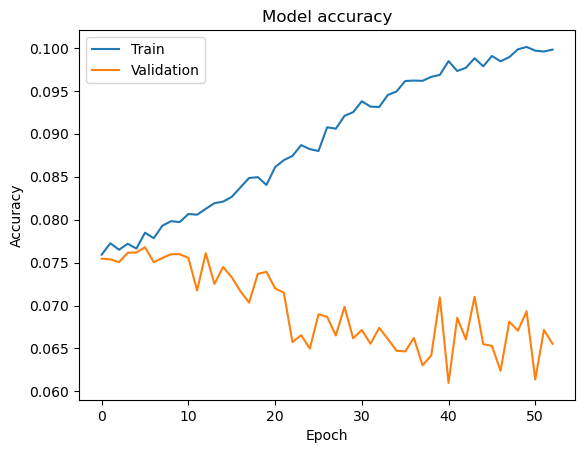

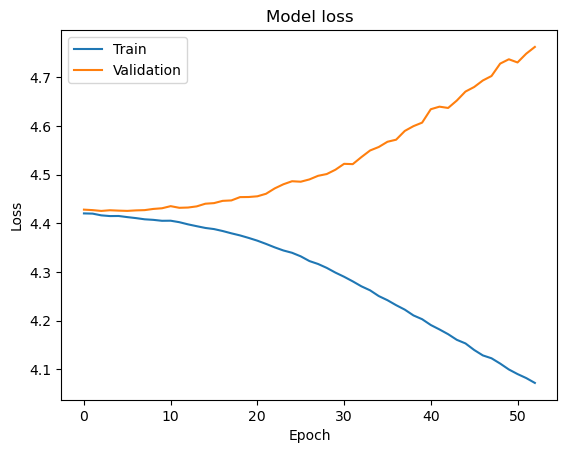

In [110]:
# Plot training & validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [41]:
X_train.shape

(124, 1024)